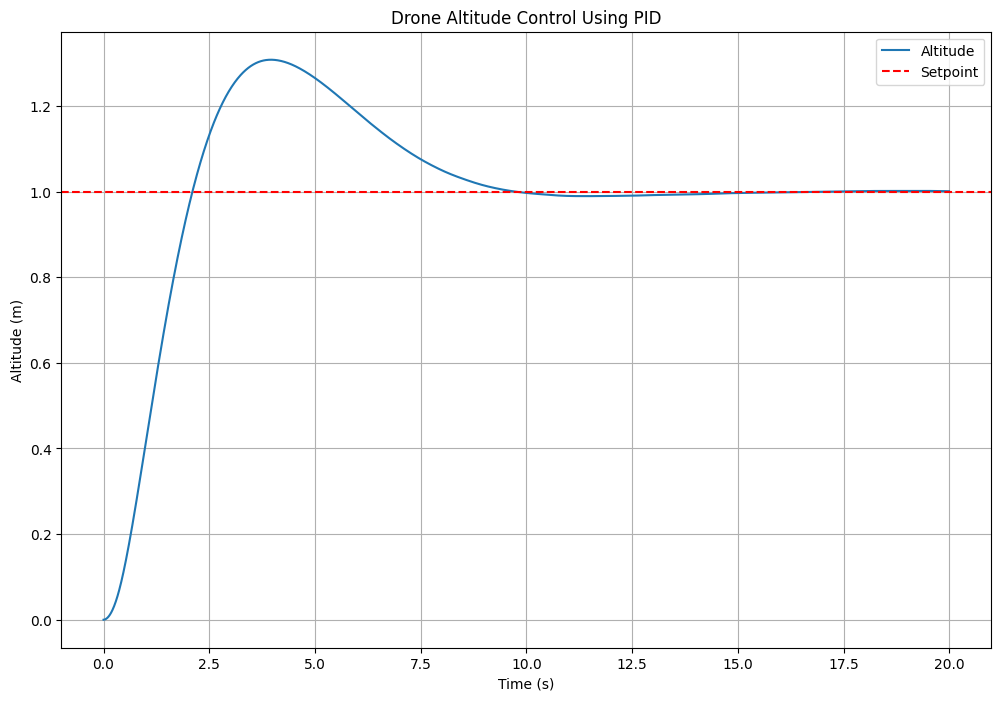

In [85]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.signal import butter, filtfilt
from sklearn.metrics import mean_squared_error

# Parameters
sampling_rate = 100  # Hz
duration = 20        # seconds
t = np.arange(0, duration, 1/sampling_rate)
dt = 1 / sampling_rate
noise_std = 0.02     # Standard deviation for noise
setpoint = 1.0       # Desired altitude in meters
f = 500              # Focal length in pixels
c_x, c_y = 320, 240  # Principal point
width, height = 640, 480  # Image dimensions

# Simulate IMU acceleration with noise (m/s^2)
true_acceleration = np.zeros_like(t)
imu_acceleration = true_acceleration + np.random.normal(0, noise_std, len(t))

# Apply low-pass filter to IMU acceleration
def low_pass_filter(data, cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)

imu_acceleration_filtered = low_pass_filter(imu_acceleration, cutoff=2.0, fs=sampling_rate)

# PID Controller for Altitude Control
class PIDController:
    def __init__(self, kp, ki, kd, setpoint, max_integral=10.0, max_output=1.0):
        self.kp = kp
        self.ki = ki
        self.kd = kd
        self.setpoint = setpoint
        self.previous_error = 0
        self.integral = 0
        self.max_integral = max_integral
        self.max_output = max_output
        self.previous_derivative = 0

    def update(self, current_value, dt):
        error = self.setpoint - current_value
        self.integral += error * dt
        self.integral = np.clip(self.integral, -self.max_integral, self.max_integral)
        derivative = (error - self.previous_error) / dt
        alpha = 0.8  # Low-pass filter coefficient
        derivative = alpha * derivative + (1 - alpha) * self.previous_derivative
        self.previous_derivative = derivative
        output = self.kp * error + self.ki * self.integral + self.kd * derivative
        output = np.clip(output, -self.max_output, self.max_output)
        self.previous_error = error
        return output

# Initialize Altitude Control
altitude = np.zeros_like(t)
velocity = np.zeros_like(t)
control_signal_history = np.zeros_like(t)
pid = PIDController(kp=1.8, ki=0.6, kd=2.5, setpoint=setpoint)

# Altitude Simulation Loop
for i in range(1, len(t)):
    control_signal = pid.update(altitude[i-1], dt)
    velocity[i] = velocity[i-1] + (imu_acceleration_filtered[i] + control_signal) * dt
    altitude[i] = altitude[i-1] + velocity[i] * dt
    control_signal_history[i] = control_signal

# Visualization of Altitude Control
plt.figure(figsize=(12, 8))
plt.plot(t, altitude, label='Altitude')
plt.axhline(y=setpoint, color='r', linestyle='--', label='Setpoint')
plt.xlabel('Time (s)')
plt.ylabel('Altitude (m)')
plt.title('Drone Altitude Control Using PID')
plt.legend()
plt.grid(True)
plt.show()




Simulated camera feed and IMU data generated!
RMSE (Altitude): 30.5083 m


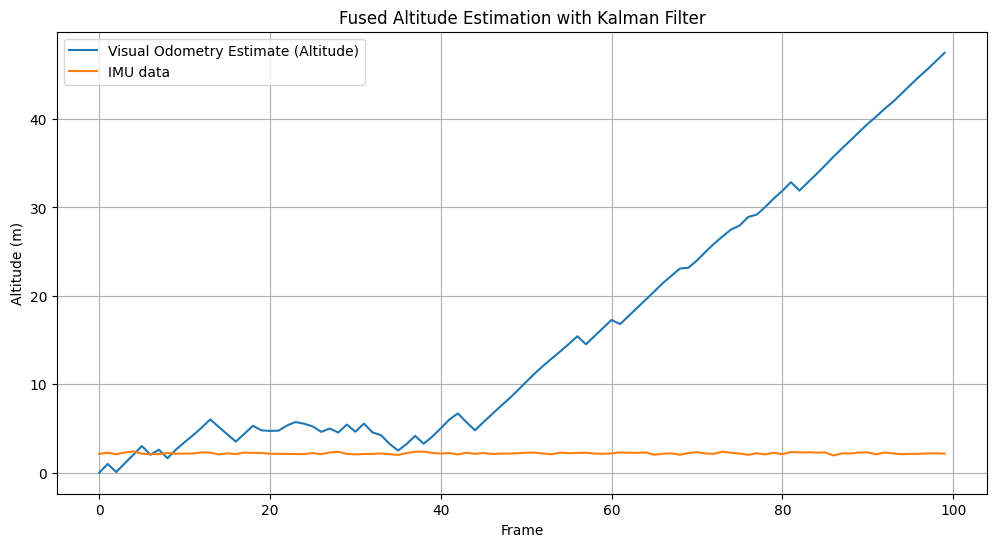

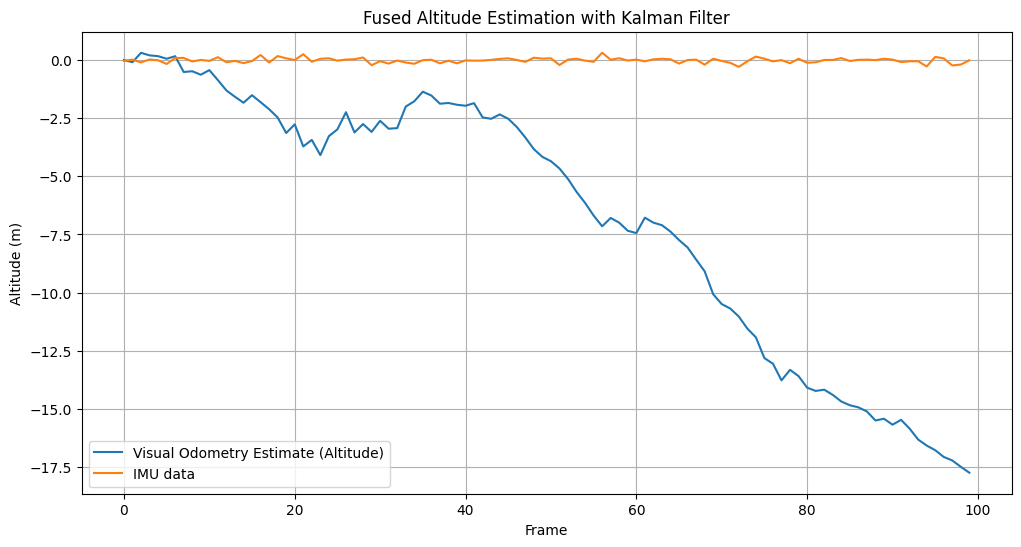

In [83]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

import cv2
import numpy as np
import os

# Parameters
frame_size = (640, 480)
num_frames = 100
num_landmarks = 50
dt = 1.0 / 30.0  # Time between frames in seconds

# Camera intrinsic matrix
focal_length = 800
camera_center = (frame_size[0] // 2, frame_size[1] // 2)
K = np.array([
    [focal_length, 0, camera_center[0]],
    [0, focal_length, camera_center[1]],
    [0, 0, 1]
], dtype=np.float64)

# Static 3D landmarks (fixed in the environment)
landmarks_3D = np.random.uniform(-5, 5, (num_landmarks, 3))  # Random points in 3D
landmarks_3D[:, 2] += 5  # Ensure landmarks are in front of the camera

# Initialize drone state
drone_position = np.array([0.0, 0.0, 10.0])  # Start 10m from landmarks
velocity = np.array([0.0, 0.0, 0.0])  # Initial velocity
rotation_vector = np.array([0.0, 0.0, 0.0])  # No initial rotation

# IMU noise parameters
sigma_gyro = 0.01  
sigma_accel = 0.1  
g = 9.81  
thrust = 12.0  

# Folder to save frames and IMU data
#
frames_folder = "frames_new"
os.makedirs(frames_folder, exist_ok=True)
imu_data = []

# Simulate camera feed and IMU data
for frame_idx in range(num_frames):
    # Simulate IMU data
    net_acceleration_z = thrust - g  # Constant upward thrust
    a_inertial = np.array([0.0, 0.0, net_acceleration_z])  # Acceleration in world frame

    # Add noise to acceleration
    a_body_noisy = a_inertial + np.random.normal(0, sigma_accel, 3)

    # Update velocity and position using noisy acceleration
    velocity += a_body_noisy * dt  # Update velocity
    drone_position += velocity * dt  # Update position

    # Simulate rotation
    angular_velocity = np.array([0.0, 0.01, 0.0])  # Rotation about the Y-axis
    rotation_vector += angular_velocity * dt

    # Compute rotation matrix
    rotation_matrix, _ = cv2.Rodrigues(rotation_vector)

    # Add noise to gyroscope readings
    omega_noisy = angular_velocity + np.random.normal(0, sigma_gyro, 3)

    # Append IMU data
    imu_data.append({'gyro': omega_noisy, 'accel': a_body_noisy})

    # Transform landmarks into camera coordinates
    transformed_landmarks = (rotation_matrix @ (landmarks_3D - drone_position).T).T

    # Project 3D landmarks to 2D
    projected_points, _ = cv2.projectPoints(transformed_landmarks, np.zeros(3), np.zeros(3), K, None)
    projected_points = projected_points.squeeze().astype(int)

    # Create blank frame
    frame = np.zeros((frame_size[1], frame_size[0], 3), dtype=np.uint8)

    # Draw landmarks
    for point in projected_points:
        if 0 <= point[0] < frame_size[0] and 0 <= point[1] < frame_size[1]:
            cv2.circle(frame, tuple(point), 5, (0, 255, 0), -1)

    # Save the frame
    frame_path = os.path.join(frames_folder, f"frame_{frame_idx:03d}.png")
    cv2.imwrite(frame_path, frame)

print("Simulated camera feed and IMU data generated!")


def display_featured_track_images():
    """Displays images from the 'featured_track' directory using OpenCV."""

    directory = "feature_tracks"

    if not os.path.exists(directory):
        print(f"Directory '{directory}' not found.")
        return

    for filename in os.listdir(directory):
        if filename.endswith(('.jpg', '.jpeg', '.png')):
            image_path = os.path.join(directory, filename)
            image = cv2.imread(image_path)

            if image is not None:
                cv2.imshow(filename, image)
                key = cv2.waitKey(1) & 0xFF  # Wait for a key press
                if key == ord('q'):
                    break
                cv2.destroyAllWindows()
            else:
                print(f"Error loading image: {image_path}")
frames_folder = "frames_news"
# Kalman Filter for Altitude Estimation
class KalmanFilter:
    def __init__(self, dt, Q, R, initial_state, initial_covariance):
        self.dt = dt
        self.Q = Q  # Process noise covariance
        self.R = R  # Measurement noise covariance
        self.x = initial_state  # Initial state (position, velocity)
        self.P = initial_covariance  # Initial covariance matrix

    def predict(self, acceleration):
        F = np.array([[1, self.dt],
                      [0, 1]])
        B = np.array([[0.5 * self.dt**2],
                      [self.dt]])
        self.x = F @ self.x + B * acceleration
        self.P = F @ self.P @ F.T + self.Q

    def update(self, measurement):
        H = np.array([[1, 0]])
        S = H @ self.P @ H.T + self.R
        K = self.P @ H.T @ np.linalg.inv(S)
        self.x = self.x + K @ (measurement - H @ self.x)
        self.P = (np.eye(2) - K @ H) @ self.P



def estimates_motion_with_vio(frames_folder, imu_data, dt):
    # Feature detector and matcher
    detector = cv2.ORB_create()
    bf_matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    # Load frames
    frame_files = sorted([f for f in os.listdir(frames_folder) if f.endswith('.png')])
    prev_frame = cv2.imread(os.path.join(frames_folder, frame_files[0]), cv2.IMREAD_GRAYSCALE)
    prev_keypoints, prev_descriptors = detector.detectAndCompute(prev_frame, None)

    feature_tracks = {}
    global_positions = [np.zeros(3)]  # Start at origin
    global_rotations = [np.eye(3)]  # Start with identity rotation

    # Process each frame
    for frame_idx in range(1, len(frame_files)):
        # Load current frame
        frame = cv2.imread(os.path.join(frames_folder, frame_files[frame_idx]), cv2.IMREAD_GRAYSCALE)
        frame_feature = frame.copy()  # Copy for drawing feature tracks
        keypoints, descriptors = detector.detectAndCompute(frame, None)

        # Get IMU data
        imu_gyro = imu_data[frame_idx]['gyro']
        imu_accel = imu_data[frame_idx]['accel']

        # Integrate gyroscope to estimate rotation
        delta_R_imu, _ = cv2.Rodrigues(imu_gyro * dt)
        global_rotation_prev = global_rotations[-1]
        global_rotation_pred = global_rotation_prev @ delta_R_imu.T

        # Match features
        if prev_descriptors is None or descriptors is None:
            print("No descriptors to match.")
            continue

        matches = bf_matcher.match(prev_descriptors, descriptors)
        matches = sorted(matches, key=lambda x: x.distance)

        # Ensure enough matches
        if len(matches) < 5:
            print(f"Not enough matches to estimate motion at frame {frame_idx}.")
            continue

        # Extract matched points
        prev_pts = np.float32([prev_keypoints[m.queryIdx].pt for m in matches])
        curr_pts = np.float32([keypoints[m.trainIdx].pt for m in matches])

        # Draw feature tracks
        for match in matches:
            prev_kp = tuple(map(int, prev_keypoints[match.queryIdx].pt))
            curr_kp = tuple(map(int, keypoints[match.trainIdx].pt))
            if match.queryIdx not in feature_tracks:
                feature_tracks[match.queryIdx] = [prev_kp]
            feature_tracks[match.queryIdx].append(curr_kp)
            cv2.line(frame_feature, prev_kp, curr_kp, (255, 0, 0), 2)
            # Save the frame with feature tracks
        
            # Save frame if needed
            feature_folder = "feature_tracks"
            os.makedirs(feature_folder, exist_ok=True)
            cv2.imwrite(os.path.join(feature_folder, f"frame_{frame_idx:03d}.png"), frame_feature)
        
        # After the loop, destroy all OpenCV windows
        cv2.destroyAllWindows()

        # Estimate motion using Essential Matrix
        E, _ = cv2.findEssentialMat(curr_pts, prev_pts, focal=focal_length, pp=camera_center, method=cv2.RANSAC, prob=0.999, threshold=1.0)

        # Recover pose
        _, R_rel, t_rel, _ = cv2.recoverPose(E, curr_pts, prev_pts, focal=focal_length, pp=camera_center)

        # Combine IMU and VO estimates
        R_combined = global_rotation_pred @ R_rel
        global_rotations.append(R_combined)

        # Convert motion to global coordinates
        camera_position = -R_combined.T @ t_rel.flatten()
        global_position = global_positions[-1] + camera_position
        global_positions.append(global_position)

      
        # Update previous frame and keypoints
        prev_frame = frame
        prev_keypoints, prev_descriptors = keypoints, descriptors

    return np.array(global_positions)

# Ensure global_positions is properly calculated with 3D positions

global_positions = estimates_motion_with_vio(frames_folder, imu_data, dt)


#display_featured_track_images()

# Initialize Kalman Filter
initial_state = np.array([[drone_position[2]], [0.0]])  # Initial altitude and velocity
initial_covariance = np.eye(2) * 0.1
Q = np.array([[0.005, 0], [0, 0.8]])  # Process noise covariance
R = np.array([[1.5]])  # Measurement noise covariance
kalman = KalmanFilter(dt, Q, R, initial_state, initial_covariance)

# Run Kalman Filter with Altitude and Visual Odometry Data
fused_position = np.zeros(num_frames)
fused_velocity = np.zeros(num_frames)
position_covariance = np.zeros(num_frames)
velocity_covariance = np.zeros(num_frames)


for i in range(num_frames):
    imu_accel_z = imu_data[i]['accel'][2]  # Z-axis acceleration
    kalman.predict(imu_accel_z)

    # Use the z-axis from global_positions as the measurement
    visual_odometry_altitude = global_positions[i, 0]
    kalman.update(visual_odometry_altitude)

    # Store Kalman filter outputs
    fused_position[i] = kalman.x[0].item()
    fused_velocity[i] = kalman.x[1].item()
    position_covariance[i] = kalman.P[0, 0].item()
    velocity_covariance[i] = kalman.P[1, 1].item()
    
imu_accell_z = [frame['accel'][2] for frame in imu_data]


# For X axis
fused_position_x = np.zeros(num_frames)
fused_velocity_x = np.zeros(num_frames)

for i in range(num_frames):
    imu_accel_x = imu_data[i]['accel'][0]  # Y-axis acceleration
    kalman.predict(imu_accel_x)

    # Use the z-axis from global_positions as the measurement
    visual_odometry_x_estimate = global_positions[i, 0]
    kalman.update(visual_odometry_x_estimate)

    # Store Kalman filter outputs
    fused_position_x[i] = kalman.x[0].item()
    fused_velocity_x[i] = kalman.x[1].item()
    position_covariance_x[i] = kalman.P[0, 0].item()
    velocity_covariance_x[i] = kalman.P[1, 1].item()
    
imu_accell_x = [frame['accel'][0] for frame in imu_data]

# For Y axis
fused_position_y = np.zeros(num_frames)
fused_velocity_y = np.zeros(num_frames)

for i in range(num_frames):
    imu_accel_y = imu_data[i]['accel'][1]  # Y-axis acceleration
    kalman.predict(imu_accel_y)

    # Use the z-axis from global_positions as the measurement
    visual_odometry_y_estimate = global_positions[i, 1]
    kalman.update(visual_odometry_y_estimate)

    # Store Kalman filter outputs
    fused_position_y[i] = kalman.x[0].item()
    fused_velocity_y[i] = kalman.x[1].item()
    position_covariance_y[i] = kalman.P[0, 0].item()
    velocity_covariance_y[i] = kalman.P[1, 1].item()
    

imu_accell_y = [frame['accel'][0] for frame in imu_data]

# Evaluate performance
rmse = np.sqrt(mean_squared_error(global_positions[:, 2], fused_position))
print(f"RMSE (Altitude): {rmse:.4f} m")
 
# Plot Fused Position
plt.figure(figsize=(12, 6))
plt.plot(range(num_frames), global_positions[:, 2], label='Visual Odometry Estimate (Altitude)')
plt.plot(range(num_frames), imu_accell_z, label='IMU data')
plt.xlabel('Frame')
plt.ylabel('Altitude (m)')
plt.title('Fused Altitude Estimation with Kalman Filter')
plt.legend()
plt.grid(True)
plt.show()

# Plot Fused Position for y
plt.figure(figsize=(12, 6))
plt.plot(range(num_frames), global_positions[:, 0], label='Visual Odometry Estimate (Altitude)')
plt.plot(range(num_frames), imu_accell_x, label='IMU data')
plt.xlabel('Frame')
plt.ylabel('Altitude (m)')
plt.title('Fused Altitude Estimation with Kalman Filter')
plt.legend()
plt.grid(True)
plt.show()
